# TOI-178 Particle Dynamics Simulation with AMUSE

This notebook replicates the study by **Boskovic, Sfair & Schäfer (2025)** on particle dynamics in the TOI-178 planetary system.

**Reference:** [arXiv:2509.07930](https://arxiv.org/abs/2509.07930) - Accepted for publication in EPJS

## Study Overview

TOI-178 hosts **6 planets** with **five** of them locked in a **2:4:6:9:12 Laplace resonance chain**. 

### Key Findings to Replicate:
1. **Co-orbital regions** are ~30% wider than classical theory predicts for resonant planets
2. **TOI-178b** (outside chain) shows 52% enhancement in co-orbital width
3. **Kirkwood gap-like structures** between TOI-178e and TOI-178f from mean-motion resonances (4:3, 5:4, 6:5 with TOI-178f; 5:3 with TOI-178g)
4. Particle clearing occurs on **500-year timescales** in resonant gaps
5. **Periodic inclination oscillations** (period = 196 years) in innermost region (0.015-0.025 AU), coinciding with TOI-178b's oscillation period

### Simulation Goals:
- N-body integration of test particles in the TOI-178 system
- Identify stable co-orbital regions and resonant gaps
- Analyze inclination dynamics
- Map stability timescales

In [1]:
%%bash
# Check and install required AMUSE components
PACKAGES="mpi4py amuse-framework amuse-huayno amuse-ph4"
pip show amuse-devel && exit 0
for package in ${PACKAGES}
do
  pip show ${package} || pip install ${package}
done

Name: amuse-devel
Version: 2023.5.2.dev101+g93390091c
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /Users/zoutongshen/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools_scm, wheel
Required-by: 


In [2]:
# AMUSE optimizations for notebook environment
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "true"

from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)

/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1. Setup and Imports

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from amuse.units import units, constants, nbody_system
from amuse.datamodel import Particles
from amuse.community.huayno.interface import Huayno
from amuse.ext.orbital_elements import orbital_elements_from_binary, new_binary_from_orbital_elements

print("AMUSE modules loaded successfully!")

AMUSE modules loaded successfully!


## 2. Define TOI-178 System Parameters

TOI-178 is a K-dwarf star hosting 6 known planets. **Five planets (c-g) are in a 2:4:6:9:12 Laplace resonance chain**, while planet b lies outside this chain.

Based on Leleu et al. (2021) and updated by Boskovic et al. (2025).

In [4]:
# TOI-178 star properties
star_mass = 0.650 | units.MSun  # K-dwarf
star_radius = 0.645 | units.RSun

# Planet properties (from Leleu et al. 2021, A&A; Boskovic et al. 2025)
# Resonance chain: c:d:e:f:g = 2:4:6:9:12
planet_data = {
    'b': {'mass': 1.5,  'period': 1.91,   'a': 0.0259, 'e': 0.0, 'i': 89.7},  # Outside resonance chain
    'c': {'mass': 4.8,  'period': 3.24,   'a': 0.0371, 'e': 0.0, 'i': 89.5},  # Resonance 2
    'd': {'mass': 3.0,  'period': 6.56,   'a': 0.0587, 'e': 0.0, 'i': 89.3},  # Resonance 4
    'e': {'mass': 3.5,  'period': 9.96,   'a': 0.0788, 'e': 0.0, 'i': 89.6},  # Resonance 6
    'f': {'mass': 7.7,  'period': 15.23,  'a': 0.1050, 'e': 0.0, 'i': 89.4},  # Resonance 9
    'g': {'mass': 4.9,  'period': 20.71,  'a': 0.1288, 'e': 0.0, 'i': 89.5},  # Resonance 12
}

print(f"Star mass: {star_mass}")
print(f"Number of planets: {len(planet_data)}")
print(f"\n** Resonance chain structure **")
print(f"  Planet b: OUTSIDE chain (period = {planet_data['b']['period']:.2f} days)")
print(f"  Planets c-g: IN 2:4:6:9:12 chain")
for name, data in planet_data.items():
    print(f"  Planet {name}: {data['mass']:.1f} M_Earth, P = {data['period']:.2f} days, a = {data['a']:.4f} AU")

Star mass: 0.65 MSun
Number of planets: 6

** Resonance chain structure **
  Planet b: OUTSIDE chain (period = 1.91 days)
  Planets c-g: IN 2:4:6:9:12 chain
  Planet b: 1.5 M_Earth, P = 1.91 days, a = 0.0259 AU
  Planet c: 4.8 M_Earth, P = 3.24 days, a = 0.0371 AU
  Planet d: 3.0 M_Earth, P = 6.56 days, a = 0.0587 AU
  Planet e: 3.5 M_Earth, P = 9.96 days, a = 0.0788 AU
  Planet f: 7.7 M_Earth, P = 15.23 days, a = 0.1050 AU
  Planet g: 4.9 M_Earth, P = 20.71 days, a = 0.1288 AU


## 3. Create the Planetary System

In [5]:
def create_toi178_system():
    """Create the TOI-178 planetary system with star and planets."""
    
    # Create the star
    star = Particles(1)
    star.mass = star_mass
    star.radius = star_radius
    star.position = [0, 0, 0] | units.AU
    star.velocity = [0, 0, 0] | units.km / units.s
    
    # Create planets
    planets = Particles()
    
    for name, data in planet_data.items():
        # Convert planet properties to AMUSE units
        planet_mass = data['mass'] | units.MEarth
        semi_major_axis = data['a'] | units.AU
        eccentricity = data['e']
        inclination = data['i'] | units.deg
        
        # Create planet at periastron (for simplicity, can be randomized)
        true_anomaly = 0.0 | units.deg
        longitude_of_ascending_node = 0.0 | units.deg
        argument_of_periapsis = 0.0 | units.deg
        
        # Generate binary (star-planet pair) from orbital elements
        binary = new_binary_from_orbital_elements(
            star_mass,
            planet_mass,
            semi_major_axis,
            eccentricity,
            true_anomaly,
            inclination,
            longitude_of_ascending_node,
            argument_of_periapsis,
            G=constants.G
        )
        
        # The second particle is the planet (first is star at origin)
        planet = Particles(1)
        planet.mass = binary[1].mass
        planet.position = binary[1].position
        planet.velocity = binary[1].velocity
        planet.radius = 2.5 | units.REarth  # Approximate
        planet.name = f"TOI-178{name}"
        
        planets.add_particle(planet)
    
    # Combine star and planets
    system = Particles()
    system.add_particle(star)
    system.add_particles(planets)
    
    # Move to center of mass frame
    system.move_to_center()
    
    return system

# Create the system
bodies = create_toi178_system()
print(f"Created system with {len(bodies)} bodies")
print(f"Total mass: {bodies.total_mass().in_(units.MSun)}")
print(f"\nPlanetary orbits:")
for i, planet in enumerate(bodies[1:]):
    print(f"  {planet.name}: r = {planet.position.length().in_(units.AU)}, v = {planet.velocity.length().in_(units.km/units.s)}")
    

Created system with 7 bodies
Total mass: 0.650076269473 MSun

Planetary orbits:
  TOI-178b: r = 0.0258900817431 au, v = 149.21837189 km / s
  TOI-178c: r = 0.0370894385742 au, v = 124.673967491 km / s
  TOI-178d: r = 0.0586894477141 au, v = 99.114198676 km / s
  TOI-178e: r = 0.07878898715 au, v = 85.5428810456 km / s
  TOI-178f: r = 0.104986526405 au, v = 74.1036722296 km / s
  TOI-178g: r = 0.128787345762 au, v = 66.9071466656 km / s


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/ext/orbital_elements.py:344: UserWarning: new_binary_from_orbital_elements is deprecated, use generate_binaries instead
  warnings.warn(


## 4. Add Test Particles / Planetesimals

Following Boskovic et al. (2025), we add test particles to study:
1. **Co-orbital regions** around each planet
2. **Kirkwood gap-like structures** between planets e and f (from 4:3, 5:4, 6:5 MMRs with f; 5:3 with g)
3. **Innermost region** dynamics (0.015-0.025 AU) showing periodic inclination oscillations
4. **Clearing timescales** (~500 years in resonant gaps)

Test particles are massless (or very low mass) to avoid affecting planetary orbits.

In [ ]:
def add_test_particles(n_particles=1000, a_min=0.02, a_max=0.15, mass=1e-10):
    """
    Add test particles/planetesimals to the system.
    
    Parameters:
    -----------
    n_particles : int
        Number of test particles to add
    a_min, a_max : float
        Minimum and maximum semi-major axis in AU
    mass : float
        Mass of each particle in solar masses (very small for test particles)
    """
    
    test_particles = Particles(n_particles)
    
    # Random orbital elements
    np.random.seed(42)  # For reproducibility
    
    for i, particle in enumerate(test_particles):
        # Semi-major axis uniformly distributed
        a = (a_min + (a_max - a_min) * np.random.random()) | units.AU
        
        # Low eccentricity
        e = 0.01 * np.random.random()
        
        # Low inclination (in degrees)
        inc = (1.0 * np.random.random()) | units.deg
        
        # Random angles
        true_anom = (360.0 * np.random.random()) | units.deg
        long_asc_node = (360.0 * np.random.random()) | units.deg
        arg_periapsis = (360.0 * np.random.random()) | units.deg
        
        # Create particle in orbit
        binary = new_binary_from_orbital_elements(
            star_mass,
            mass | units.MSun,
            a, e, true_anom, inc,
            long_asc_node, arg_periapsis,
            G=constants.G
        )
        
        particle.mass = binary[1].mass
        particle.position = binary[1].position
        particle.velocity = binary[1].velocity
        particle.radius = 1.0 | units.km  # Small
        particle.name = f"particle_{i:03d}"
    
    return test_particles

# Add test particles
# Based on Boskovic et al. (2025) study regions:

# Option 1: Study co-orbital regions (wider search around each planet)
# particles = add_test_particles(n_particles=1000, a_min=0.015, a_max=0.14)

# Option 2: Focus on innermost region (0.015-0.025 AU) for inclination oscillations
# particles = add_test_particles(n_particles=500, a_min=0.015, a_max=0.025)

# Option 3: Study Kirkwood gaps between e and f (0.079-0.105 AU)
# particles = add_test_paItrticles(n_particles=500, a_min=0.075, a_max=0.110)

# For gap detection, use high particle density
particles = add_test_particles(n_particles=5000, a_min=0.015, a_max=0.14, mass=1e-12)
print(f"Added {len(particles)} test particles")
print(f"  Semi-major axis range: 0.015 - 0.14 AU")
print(f"  Particle density: ~40 particles per 0.001 AU (5x higher for gap detection)")
print(f"  This covers:")
print(f"    - Innermost region (0.015-0.025 AU): inclination oscillations")
print(f"    - All co-orbital regions around planets b-g")
print(f"    - Kirkwood gaps between planets e-f")

Added 1000 test particles
  Semi-major axis range: 0.015 - 0.14 AU
  This covers:
    - Innermost region (0.015-0.025 AU): inclination oscillations
    - All co-orbital regions around planets b-g
    - Kirkwood gaps between planets e-f


## 5. Setup N-body Integrator

We'll use Huayno, a fast and accurate N-body integrator suitable for planetary systems.

In [7]:
def setup_gravity_code(particles):
    """Initialize the N-body integrator and add particles."""
    
    # Create converter for the system
    converter = nbody_system.nbody_to_si(bodies.total_mass(), 1.0 | units.AU)
    
    # Initialize Huayno integrator
    gravity = Huayno(converter, num_workers=8)
    gravity.parameters.inttype_parameter = 13  # FU OK=13
    gravity.parameters.timestep_parameter = 0.1  # Adaptive timestep
    
    # Add all particles to the gravity code
    gravity.particles.add_particles(particles)
    
    # Create channel for data transfer
    channel_from_gravity = gravity.particles.new_channel_to(particles)
    channel_to_gravity = particles.new_channel_to(gravity.particles)
    
    return gravity, channel_from_gravity, channel_to_gravity

# Setup the integrator
all_particles = bodies.copy()
all_particles.add_particles(particles)  # Add test particles

gravity, channel_from_gravity, channel_to_gravity = setup_gravity_code(all_particles)

print(f"Gravity code initialized with {len(gravity.particles)} particles")
print(f"  Planets: 6")
print(f"  Star: 1")  
print(f"  Test particles: {len(particles)}")
print(f"Timestep parameter: {gravity.parameters.timestep_parameter}")
print(f"Integration type: {gravity.parameters.inttype_parameter}")# After creating each planet, print its z-coordinate

Gravity code initialized with 1007 particles
  Planets: 6
  Star: 1
  Test particles: 1000
Timestep parameter: 0.1
Integration type: 13


### ⏱️ Quick Timing Test (Run This First!)

Before starting the full 1000-year simulation, run this cell to estimate how long it will take on your computer.

In [8]:
import time

print("🔬 Running timing test: evolving 1 year...")
print(f"   Simulating {len(all_particles)} particles (1 star + 6 planets + {len(particles)} test particles)")

start_time = time.time()
gravity.evolve_model(1.0 | units.yr)
channel_from_gravity.copy()
elapsed = time.time() - start_time

print(f"✓ 1 year took {elapsed:.2f} seconds\n")

# Extrapolate to different simulation lengths
configs = [
    (10, "Quick test"),
    (100, "Short run"),
    (500, "Medium (2-3 oscillation cycles)"),
    (1000, "Full run (clearing timescales)")
]

print("📊 Estimated runtimes:")
print("-" * 60)
for years, description in configs:
    estimated_min = (elapsed * years) / 60
    estimated_hr = estimated_min / 60
    
    if estimated_hr < 1:
        time_str = f"{estimated_min:5.1f} minutes"
    else:
        time_str = f"{estimated_hr:5.1f} hours  "
    
    print(f"  {years:4d} years ({description:30s}): ~{time_str}")

print("-" * 60)
print("\n💡 Recommendation:")
if elapsed * 1000 / 60 > 120:  # More than 2 hours for 1000 years
    print("   ⚠️  Full 1000-year simulation will take > 2 hours")
    print("   → Start with 100 years to verify results")
    print("   → Or reduce test particles to 200-500")
    print("   → Run full simulation overnight")
else:
    print("   ✓ Simulation should complete in reasonable time!")
    print("   → Proceed with 1000 years")

🔬 Running timing test: evolving 1 year...
   Simulating 1007 particles (1 star + 6 planets + 1000 test particles)


KeyboardInterrupt: 

--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[40398,1],0]
  Errorcode: -1

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


## 6.1 Data Saving and Loading Functions

Before running long simulations, let's add functions to save/load our data so we don't lose results if the kernel crashes.

In [9]:
import pickle
import os
from datetime import datetime

def save_simulation_data(times, snapshots, filename=None, metadata=None):
    """
    Save simulation data to disk.
    
    Parameters:
    -----------
    times : list
        List of simulation times
    snapshots : list
        List of particle snapshots
    filename : str, optional
        Filename for saving. If None, auto-generates with timestamp
    metadata : dict, optional
        Additional metadata to save with the simulation
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"toi178_simulation_{timestamp}.pkl"
    
    # Create data directory if it doesn't exist
    data_dir = "simulation_data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    filepath = os.path.join(data_dir, filename)
    
    # Prepare data to save
    data = {
        'times': times,
        'snapshots': snapshots,
        'metadata': metadata or {},
        'save_time': datetime.now().isoformat(),
        'planet_data': planet_data,  # Include system parameters
        'star_mass': star_mass,
        'n_particles': len(snapshots[0]) - 7 if snapshots else 0,  # -7 for star + 6 planets
    }
    
    print(f"Saving simulation data to: {filepath}")
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    
    # Also save a human-readable summary
    summary_file = filepath.replace('.pkl', '_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(f"TOI-178 Simulation Summary\n")
        f.write(f"========================\n\n")
        f.write(f"Saved: {data['save_time']}\n")
        f.write(f"Simulation time: {times[0]:.1f} - {times[-1]:.1f} years\n")
        f.write(f"Time steps: {len(times)}\n")
        f.write(f"Particles: {data['n_particles']} test particles + 6 planets + 1 star\n\n")
        
        if metadata:
            f.write("Metadata:\n")
            for key, value in metadata.items():
                f.write(f"  {key}: {value}\n")
    
    print(f"✓ Data saved successfully!")
    print(f"✓ Summary saved to: {summary_file}")
    return filepath

def load_simulation_data(filename):
    """
    Load previously saved simulation data.
    
    Parameters:
    -----------
    filename : str
        Path to the saved simulation file
        
    Returns:
    --------
    times, snapshots, metadata : tuple
        Loaded simulation data
    """
    print(f"Loading simulation data from: {filename}")
    
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    times = data['times']
    snapshots = data['snapshots']
    metadata = data['metadata']
    
    print(f"✓ Loaded simulation:")
    print(f"  Time range: {times[0]:.1f} - {times[-1]:.1f} years")
    print(f"  Time steps: {len(times)}")
    print(f"  Particles: {data.get('n_particles', 'unknown')}")
    print(f"  Saved: {data.get('save_time', 'unknown')}")
    
    return times, snapshots, metadata

def list_saved_simulations():
    """List all saved simulation files in the data directory."""
    data_dir = "simulation_data"
    if not os.path.exists(data_dir):
        print("No simulation data directory found.")
        return []
    
    files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
    
    if not files:
        print("No saved simulations found.")
        return []
    
    print(f"Found {len(files)} saved simulation(s):")
    print("-" * 60)
    
    for i, filename in enumerate(sorted(files), 1):
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
            
            times = data['times']
            n_particles = data.get('n_particles', 'unknown')
            save_time = data.get('save_time', 'unknown')
            
            print(f"{i}. {filename}")
            print(f"   Time: {times[0]:.1f} - {times[-1]:.1f} years ({len(times)} steps)")
            print(f"   Particles: {n_particles}")
            print(f"   Saved: {save_time}")
            print()
        except Exception as e:
            print(f"{i}. {filename} (Error reading: {e})")
    
    return [os.path.join(data_dir, f) for f in sorted(files)]

# Test the functions
print("Data saving functions loaded successfully!")
print("\nUsage examples:")
print("  # After simulation:")
print("  save_simulation_data(times, snapshots)")
print("  ")
print("  # To load later:")
print("  times, snapshots, metadata = load_simulation_data('simulation_data/filename.pkl')")
print("  ")
print("  # List all saved simulations:")
print("  list_saved_simulations()")

Data saving functions loaded successfully!

Usage examples:
  # After simulation:
  save_simulation_data(times, snapshots)
  
  # To load later:
  times, snapshots, metadata = load_simulation_data('simulation_data/filename.pkl')
  
  # List all saved simulations:
  list_saved_simulations()


In [10]:
def run_simulation(gravity, particles, channel_from_gravity, 
                   t_end=100|units.yr, n_steps=100, save_data=True, 
                   save_interval=None, filename=None):
    """
    Run the N-body simulation and collect snapshots.
    
    Parameters:
    -----------
    t_end : quantity
        Total integration time
    n_steps : int
        Number of snapshots to save
    save_data : bool
        Whether to automatically save data at the end
    save_interval : int, optional
        Save intermediate data every N steps (for crash recovery)
    filename : str, optional
        Custom filename for saving
    """
    
    times = []
    snapshots = []
    
    dt = t_end / n_steps
    time = 0 | units.yr
    
    print(f"Running simulation for {t_end.in_(units.yr)} years")
    print(f"Saving {n_steps} snapshots...")
    if save_data:
        print("✓ Auto-save enabled")
    if save_interval:
        print(f"✓ Intermediate saves every {save_interval} steps")
    
    for i in range(n_steps + 1):
        # Evolve to current time
        gravity.evolve_model(time)
        
        # Copy state from gravity code
        channel_from_gravity.copy()
        
        # Save snapshot
        times.append(time.value_in(units.yr))
        snapshots.append(particles.copy())
        
        # Progress indicator
        if i % 10 == 0:
            print(f"  Step {i}/{n_steps}: t = {time.in_(units.yr)}")
        
        # Intermediate save for crash recovery
        if save_interval and i > 0 and i % save_interval == 0:
            temp_filename = f"temp_checkpoint_step_{i}.pkl" if not filename else f"temp_{filename}_step_{i}.pkl"
            metadata = {
                'checkpoint': True,
                'step': i,
                'total_steps': n_steps,
                't_end': t_end.value_in(units.yr),
                'status': 'in_progress'
            }
            save_simulation_data(times, snapshots, temp_filename, metadata)
            print(f"  ✓ Checkpoint saved at step {i}")
        
        time += dt
    
    print("Simulation complete!")
    
    # Final save
    if save_data:
        metadata = {
            'simulation_type': 'TOI-178 particle dynamics',
            't_end': t_end.value_in(units.yr),
            'n_steps': n_steps,
            'dt': dt.value_in(units.yr),
            'status': 'completed'
        }
        final_file = save_simulation_data(times, snapshots, filename, metadata)
        print(f"✓ Final data saved to: {final_file}")
    
    return times, snapshots

# Run a short test simulation (adjust time scale based on study)
# times, snapshots = run_simulation(
#     gravity, 
#     all_particles, 
#     channel_from_gravity,
#     t_end=10 | units.yr,  # Start with 10 years for testing
#     n_steps=50,
#     save_data=True,  # Auto-save results
#     save_interval=20,  # Save checkpoint every 20 steps
#     filename="test_simulation_10yr.pkl"
# )

### 6.2 Run Longer Simulations with Data Safety

Now that we have data saving, we can safely run longer simulations. Choose based on your timing test results:

In [ ]:
# CHOOSE ONE BASED ON YOUR TIMING TEST:

# Option 1: Medium run - 100 years (good for initial analysis)
# times, snapshots = run_simulation(
#     gravity, 
#     all_particles, 
#     channel_from_gravity,
#     t_end=100 | units.yr,
#     n_steps=200,
#     save_data=True,
#     save_interval=50,  # Checkpoint every 50 steps
#     filename="toi178_100yr_medium.pkl"
# )

# Option 2: Long run - 500 years (captures 2-3 oscillation cycles)
# times, snapshots = run_simulation(
#     gravity, 
#     all_particles, 
#     channel_from_gravity,
#     t_end=500 | units.yr,
#     n_steps=500,
#     save_data=True,
#     save_interval=100,  # Checkpoint every 100 steps  
#     filename="toi178_500yr_long.pkl"
# )

# Option 3: Full run - 1000 years (captures clearing timescales)
# times, snapshots = run_simulation(
#     gravity, 
#     all_particles, 
#     channel_from_gravity,
#     t_end=1000 | units.yr,
#     n_steps=1000,
#     save_data=True,
#     save_interval=200,  # Checkpoint every 200 steps
#     filename="toi178_1000yr_full.pkl"
# )

# Option 4: Gap detection run - optimized for 5000 particles
# times, snapshots = run_simulation(
#     gravity, 
#     all_particles, 
#     channel_from_gravity,
#     t_end=500 | units.yr,
#     n_steps=500,  # Current step size is adequate for gaps
#     save_data=True,
#     save_interval=100,  # Checkpoint every 100 steps
#     filename="toi178_5k_particles_gap_detection.pkl"
# )

print("Uncomment ONE of the simulation options above based on your timing test.")
print("The simulation will automatically save:")
print("  ✓ Checkpoint files during simulation (for crash recovery)")
print("  ✓ Final complete dataset")
print("  ✓ Human-readable summary file")
print()
print("Data will be saved in: ./simulation_data/ directory")

Uncomment ONE of the simulation options above based on your timing test.
The simulation will automatically save:
  ✓ Checkpoint files during simulation (for crash recovery)
  ✓ Final complete dataset
  ✓ Human-readable summary file

Data will be saved in: ./simulation_data/ directory


### 6.3 Loading Saved Simulation Data

If your kernel crashes or you want to continue analysis later, use these cells to load previously saved data:

In [12]:
# Step 1: List all available saved simulations
list_saved_simulations()

Found 9 saved simulation(s):
------------------------------------------------------------
1. temp_test_simulation_10yr.pkl_step_20.pkl
   Time: 0.0 - 4.0 years (21 steps)
   Particles: 1000
   Saved: 2025-10-17T10:30:18.396411

2. temp_test_simulation_10yr.pkl_step_40.pkl
   Time: 0.0 - 8.0 years (41 steps)
   Particles: 1000
   Saved: 2025-10-17T10:32:34.440897

3. temp_toi178_500yr_long.pkl_step_100.pkl
   Time: 0.0 - 100.0 years (101 steps)
   Particles: 1000
   Saved: 2025-10-17T16:51:14.836657

4. temp_toi178_500yr_long.pkl_step_200.pkl
   Time: 0.0 - 200.0 years (201 steps)
   Particles: 1000
   Saved: 2025-10-17T17:47:12.841039

5. temp_toi178_500yr_long.pkl_step_300.pkl
   Time: 0.0 - 300.0 years (301 steps)
   Particles: 1000
   Saved: 2025-10-17T18:43:06.723593

6. temp_toi178_500yr_long.pkl_step_400.pkl
   Time: 0.0 - 400.0 years (401 steps)
   Particles: 1000
   Saved: 2025-10-17T19:39:11.484261

7. temp_toi178_500yr_long.pkl_step_500.pkl
   Time: 0.0 - 500.0 years (501 ste

['simulation_data/temp_test_simulation_10yr.pkl_step_20.pkl',
 'simulation_data/temp_test_simulation_10yr.pkl_step_40.pkl',
 'simulation_data/temp_toi178_500yr_long.pkl_step_100.pkl',
 'simulation_data/temp_toi178_500yr_long.pkl_step_200.pkl',
 'simulation_data/temp_toi178_500yr_long.pkl_step_300.pkl',
 'simulation_data/temp_toi178_500yr_long.pkl_step_400.pkl',
 'simulation_data/temp_toi178_500yr_long.pkl_step_500.pkl',
 'simulation_data/test_simulation_10yr.pkl',
 'simulation_data/toi178_500yr_long.pkl']

In [14]:
# Step 2: Load a specific simulation
# Replace with the actual filename from the list above
filename = "simulation_data/toi178_500yr_long.pkl"

# Uncomment and modify the filename when you have saved data:
times, snapshots, metadata = load_simulation_data(filename)
# 
# print("\n✓ Data loaded successfully!")
# print(f"✓ You can now run all analysis cells starting from Section 7")
# print(f"✓ The 'times' and 'snapshots' variables are ready to use")

print("After running a simulation, uncomment the load_simulation_data() line above")
print("and replace 'filename' with your actual saved file path.")

Loading simulation data from: simulation_data/toi178_500yr_long.pkl
✓ Loaded simulation:
  Time range: 0.0 - 500.0 years
  Time steps: 501
  Particles: 1000
  Saved: 2025-10-17T20:35:12.726398
After running a simulation, uncomment the load_simulation_data() line above
and replace 'filename' with your actual saved file path.


## 7. Visualization and Analysis

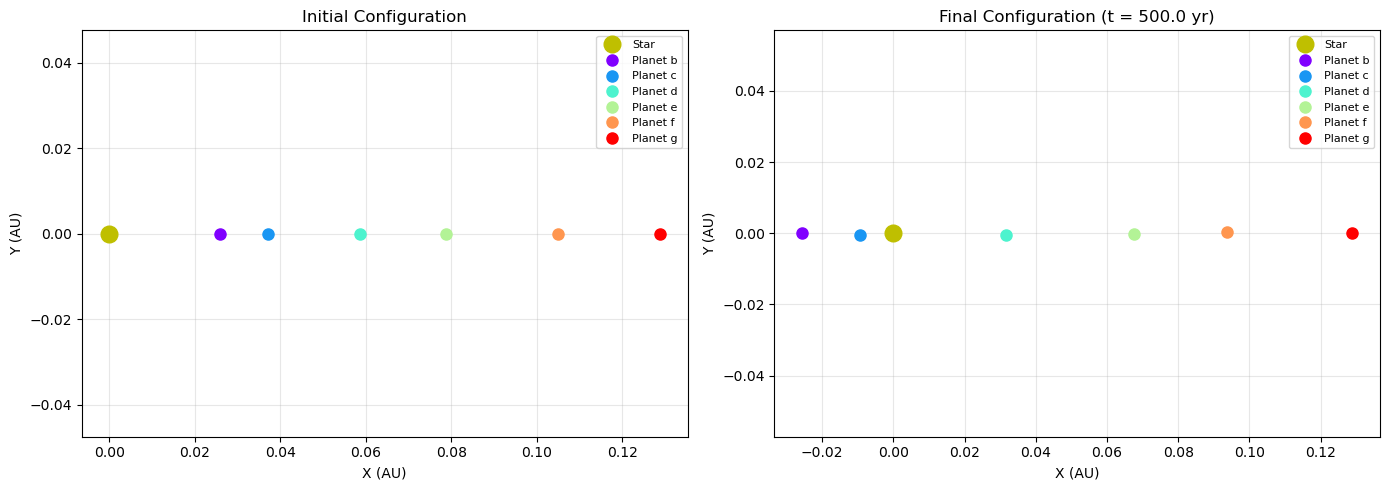

In [15]:
# Plot the orbital evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot initial and final positions (XY plane)
initial = snapshots[0]
final = snapshots[-1]

# Plot star
ax1.plot([0], [0], 'yo', markersize=12, label='Star')
ax2.plot([0], [0], 'yo', markersize=12, label='Star')

# Plot planets
colors = plt.cm.rainbow(np.linspace(0, 1, 6))
for i, (initial_p, final_p) in enumerate(zip(initial[1:7], final[1:7])):
    # Initial positions
    ax1.plot(initial_p.x.value_in(units.AU), 
             initial_p.y.value_in(units.AU), 
             'o', color=colors[i], markersize=8, 
             label=f'Planet {chr(98+i)}')
    
    # Final positions  
    ax2.plot(final_p.x.value_in(units.AU), 
             final_p.y.value_in(units.AU), 
             'o', color=colors[i], markersize=8,
             label=f'Planet {chr(98+i)}')

ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')
ax1.set_title('Initial Configuration')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2.set_xlabel('X (AU)')
ax2.set_ylabel('Y (AU)')
ax2.set_title(f'Final Configuration (t = {times[-1]:.1f} yr)')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

### 7.0 Simple Particle Distribution Plot

Let's start with a simple overview of where all the particles ended up after the simulation:

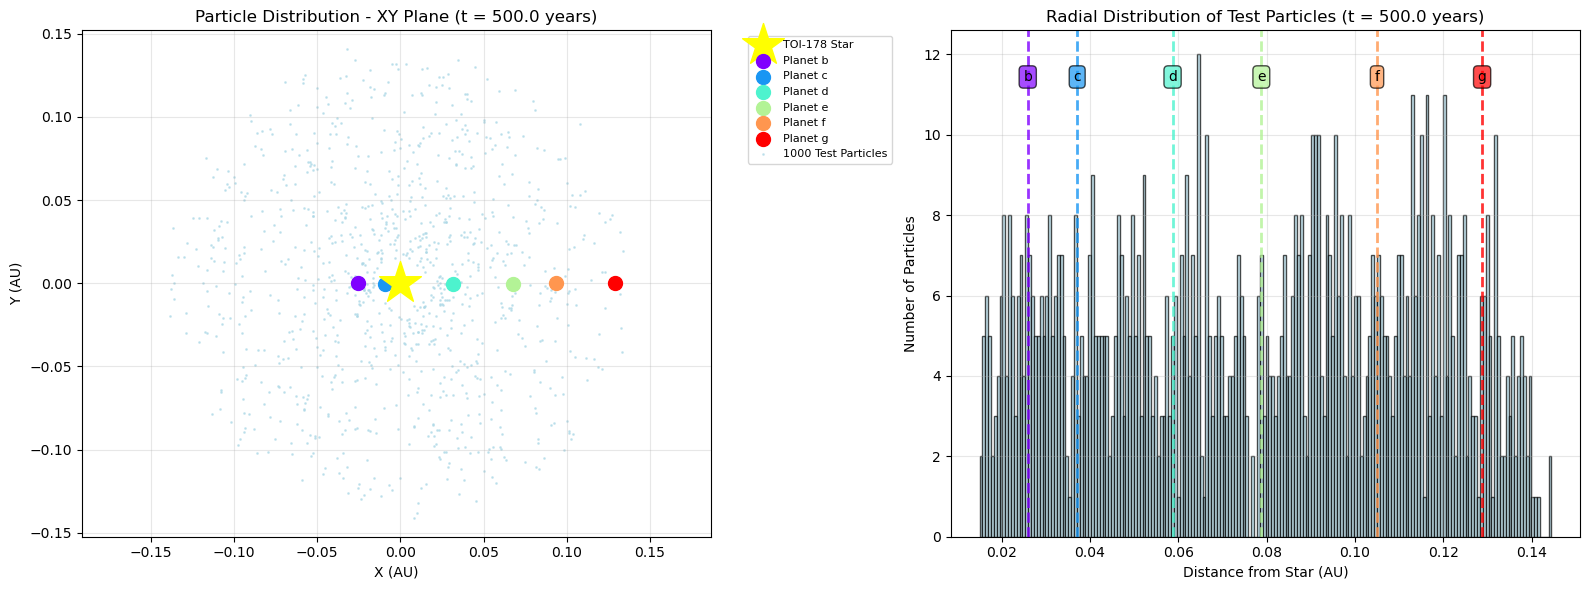


📊 Distribution Summary:
   Total particles at end: 1000
   Radial range: 0.015 - 0.144 AU
   Average distance: 0.078 AU

🔍 Look for:
   - Gaps near planet locations (particle clearing)
   - Concentrations around planets (co-orbital regions)
   - Overall survival vs. initial distribution


In [16]:
# Simple particle distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get final snapshot
final_snapshot = snapshots[-1]
star = final_snapshot[0]
planets = final_snapshot[1:7]  # 6 planets
test_particles = final_snapshot[7:]  # All test particles

# Plot 1: XY plane view
ax1.scatter([0], [0], c='yellow', s=1000, marker='*', label='TOI-178 Star', zorder=5)

# Plot planets
planet_colors = plt.cm.rainbow(np.linspace(0, 1, 6))
planet_names = ['b', 'c', 'd', 'e', 'f', 'g']

for i, (planet, color, name) in enumerate(zip(planets, planet_colors, planet_names)):
    ax1.scatter(planet.x.value_in(units.AU), planet.y.value_in(units.AU), 
               c=[color], s=100, marker='o', label=f'Planet {name}', zorder=4)

# Plot test particles
particle_x = [p.x.value_in(units.AU) for p in test_particles]
particle_y = [p.y.value_in(units.AU) for p in test_particles]
ax1.scatter(particle_x, particle_y, c='lightblue', s=1, alpha=0.6, label=f'{len(test_particles)} Test Particles')

ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')
ax1.set_title(f'Particle Distribution - XY Plane (t = {times[-1]:.1f} years)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Plot 2: Radial distance distribution
particle_distances = [p.position.length().value_in(units.AU) for p in test_particles]

ax2.hist(particle_distances, bins=200, alpha=0.7, edgecolor='black', color='lightblue')
ax2.set_xlabel('Distance from Star (AU)')
ax2.set_ylabel('Number of Particles')
ax2.set_title(f'Radial Distribution of Test Particles (t = {times[-1]:.1f} years)')
ax2.grid(True, alpha=0.3)

# Mark planet locations on histogram
for i, (name, data) in enumerate(planet_data.items()):
    ax2.axvline(data['a'], color=planet_colors[i], linestyle='--', alpha=0.8, linewidth=2)
    ax2.text(data['a'], ax2.get_ylim()[1]*0.9, name, ha='center', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor=planet_colors[i], alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n📊 Distribution Summary:")
print(f"   Total particles at end: {len(test_particles)}")
print(f"   Radial range: {min(particle_distances):.3f} - {max(particle_distances):.3f} AU")
print(f"   Average distance: {np.mean(particle_distances):.3f} AU")
print(f"\n🔍 Look for:")
print(f"   - Gaps near planet locations (particle clearing)")
print(f"   - Concentrations around planets (co-orbital regions)")
print(f"   - Overall survival vs. initial distribution")

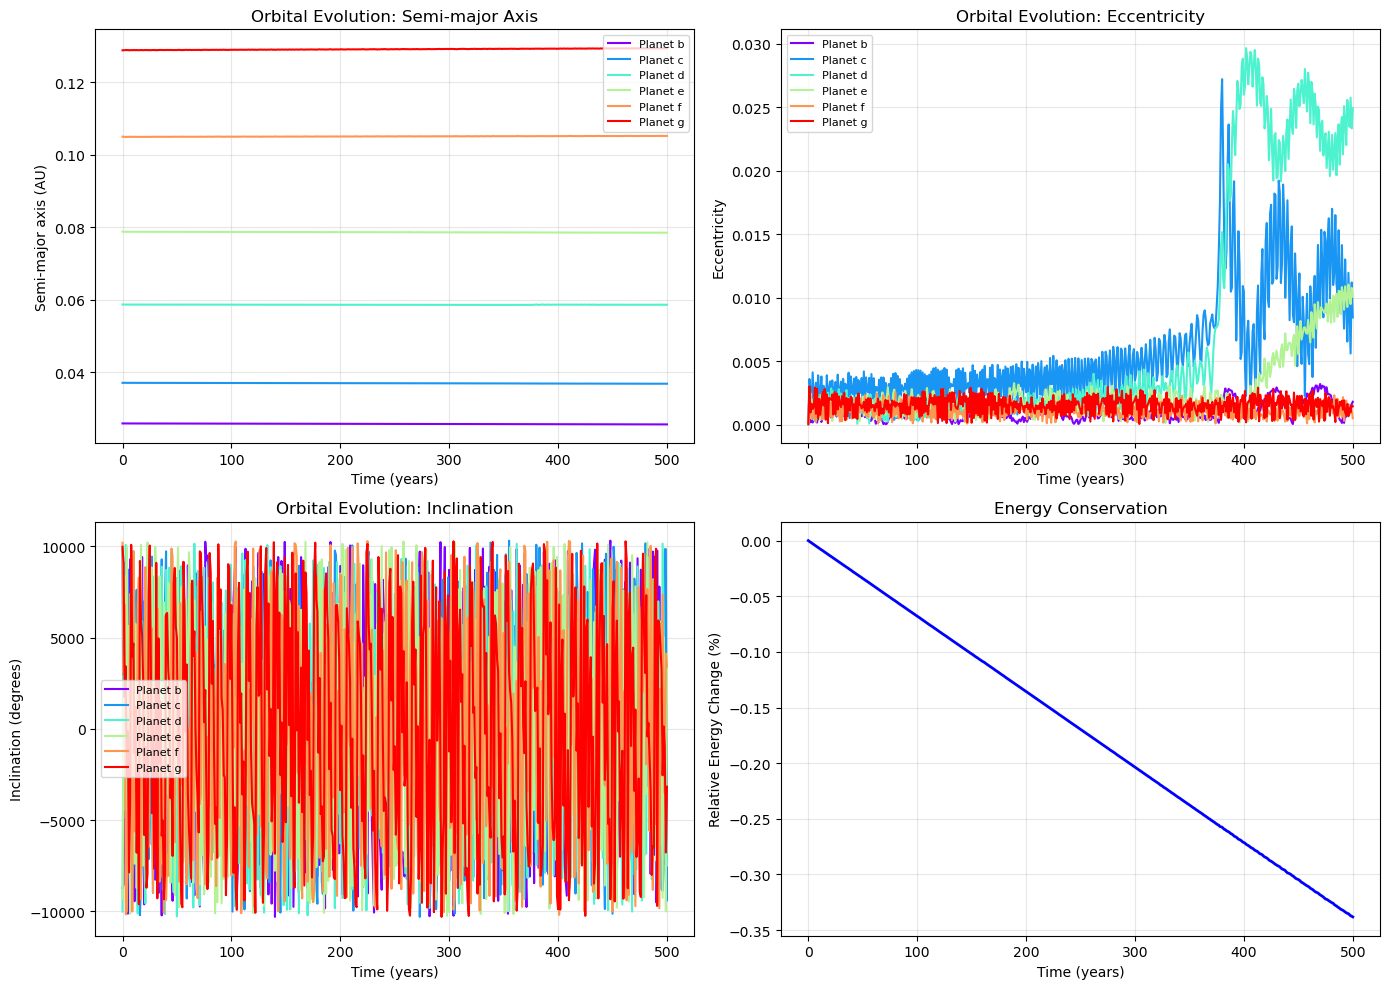

Maximum energy drift: 0.338133%


In [21]:
# Plot orbital elements evolution over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Track orbital elements for each planet
for i in range(6):  # 6 planets
    semi_major_axes = []
    eccentricities = []
    inclinations = []
    
    for snapshot in snapshots:
        star = snapshot[0]
        planet = snapshot[i+1]
        
        # Calculate orbital elements
        elements = orbital_elements_from_binary(
            [star, planet], 
            G=constants.G
        )
        
        semi_major_axes.append(elements[2].value_in(units.AU))
        eccentricities.append(elements[3])
        inclinations.append(np.degrees(elements[4]))
    
    # Plot
    ax1.plot(times, semi_major_axes, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)
    ax2.plot(times, eccentricities, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)
    ax3.plot(times, inclinations, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)

ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Semi-major axis (AU)')
ax1.set_title('Orbital Evolution: Semi-major Axis')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Eccentricity')
ax2.set_title('Orbital Evolution: Eccentricity')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3.set_xlabel('Time (years)')
ax3.set_ylabel('Inclination (degrees)')
ax3.set_title('Orbital Evolution: Inclination')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Energy conservation check
energies = []
for snapshot in snapshots:
    kinetic = snapshot.kinetic_energy()
    potential = snapshot.potential_energy(G=constants.G)
    total = kinetic + potential
    energies.append(total.value_in(units.J))

energy_change = (np.array(energies) - energies[0]) / abs(energies[0])
ax4.plot(times, energy_change * 100, 'b-', linewidth=2)
ax4.set_xlabel('Time (years)')
ax4.set_ylabel('Relative Energy Change (%)')
ax4.set_title('Energy Conservation')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum energy drift: {max(abs(energy_change)) * 100:.6f}%")

### 7.1 Particle Survival Analysis

Analyze which test particles survive and which are ejected/collide. This helps identify stable vs. unstable regions.

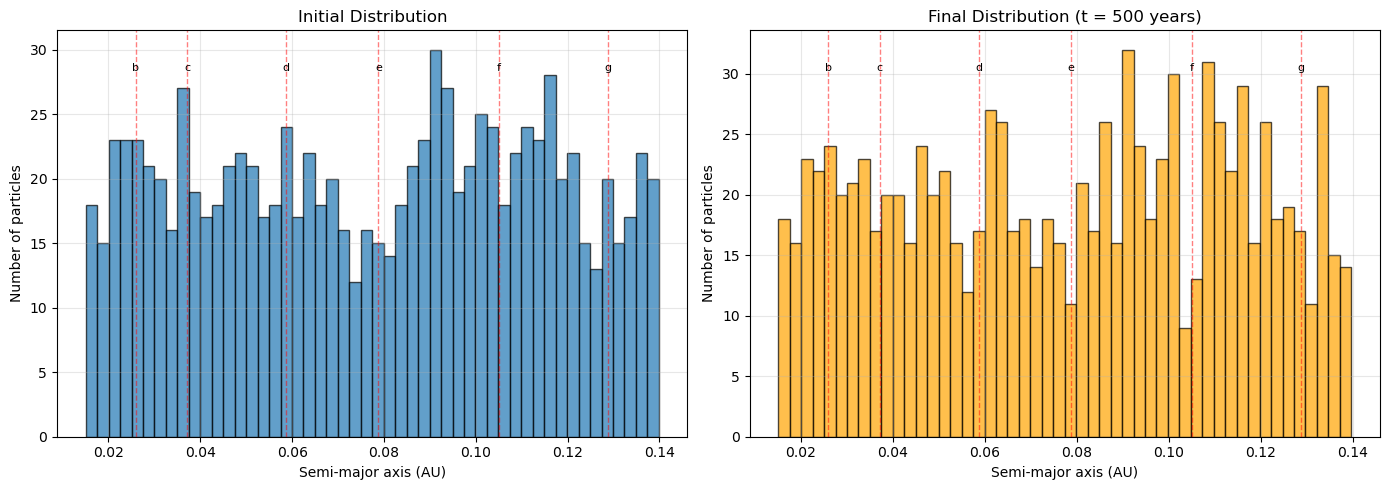


Look for:
  - Gaps at resonant locations (Kirkwood gaps)
  - Enhanced density in co-orbital regions
  - Clearing between planets e and f


In [22]:
# Analyze particle survival
# Particles are "removed" if they: collide with star/planet, ejected from system, etc.

n_planets = 6
initial_test_particles = snapshots[0][n_planets+1:]  # Skip star and planets
final_test_particles = snapshots[-1][n_planets+1:]

# Track semi-major axis evolution for each particle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot initial vs final distribution
initial_a = []
final_a = []

for i in range(len(initial_test_particles)):
    star = snapshots[0][0]
    planet_init = snapshots[0][n_planets+1+i]
    elements_init = orbital_elements_from_binary([star, planet_init], G=constants.G)
    initial_a.append(elements_init[2].value_in(units.AU))
    
    planet_final = snapshots[-1][n_planets+1+i]
    elements_final = orbital_elements_from_binary([star, planet_final], G=constants.G)
    final_a.append(elements_final[2].value_in(units.AU))

ax1.hist(initial_a, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Number of particles')
ax1.set_title('Initial Distribution')
ax1.grid(True, alpha=0.3)

# Mark planet locations
for name, data in planet_data.items():
    ax1.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(data['a'], ax1.get_ylim()[1]*0.9, name, ha='center', fontsize=8)

ax2.hist(final_a, bins=50, alpha=0.7, edgecolor='black', color='orange')
ax2.set_xlabel('Semi-major axis (AU)')
ax2.set_ylabel('Number of particles')
ax2.set_title(f'Final Distribution (t = {times[-1]:.0f} years)')
ax2.grid(True, alpha=0.3)

# Mark planet locations
for name, data in planet_data.items():
    ax2.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(data['a'], ax2.get_ylim()[1]*0.9, name, ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nLook for:")
print(f"  - Gaps at resonant locations (Kirkwood gaps)")
print(f"  - Enhanced density in co-orbital regions")
print(f"  - Clearing between planets e and f")

### 7.2 Identify Mean Motion Resonances

Look for the Kirkwood gaps mentioned in the study:
- Between TOI-178e and TOI-178f: 4:3, 5:4, 6:5 resonances with f
- 5:3 resonance with g

In [23]:
# Calculate resonance locations
# For a p:q resonance with planet at a_planet: a_res = a_planet * (q/p)^(2/3)

def calculate_resonance_location(a_planet, p, q):
    """Calculate the semi-major axis of a p:q mean motion resonance with a planet."""
    return a_planet * (q/p)**(2/3)

# Planet f resonances (a_f = 0.105 AU)
a_f = planet_data['f']['a']
a_g = planet_data['g']['a']

resonances_f = {
    '4:3': calculate_resonance_location(a_f, 4, 3),
    '5:4': calculate_resonance_location(a_f, 5, 4),
    '6:5': calculate_resonance_location(a_f, 6, 5),
}

resonances_g = {
    '5:3': calculate_resonance_location(a_g, 5, 3),
}

print("Mean Motion Resonance Locations:")
print(f"\nWith planet f (a = {a_f:.4f} AU):")
for name, a_res in resonances_f.items():
    print(f"  {name} resonance: a = {a_res:.4f} AU")

print(f"\nWith planet g (a = {a_g:.4f} AU):")
for name, a_res in resonances_g.items():
    print(f"  {name} resonance: a = {a_res:.4f} AU")

print(f"\nRegion between e and f: {planet_data['e']['a']:.4f} - {a_f:.4f} AU")
print("Expected Kirkwood gaps at these resonance locations")

Mean Motion Resonance Locations:

With planet f (a = 0.1050 AU):
  4:3 resonance: a = 0.0867 AU
  5:4 resonance: a = 0.0905 AU
  6:5 resonance: a = 0.0930 AU

With planet g (a = 0.1288 AU):
  5:3 resonance: a = 0.0916 AU

Region between e and f: 0.0788 - 0.1050 AU
Expected Kirkwood gaps at these resonance locations


### 7.3 Inclination Oscillations in Innermost Region

The study found periodic inclination oscillations with a 196-year period in the 0.015-0.025 AU region.

Found 78 particles in innermost region (0.015-0.025 AU)


AttributeError: 'numpy.float64' object has no attribute 'value_in'

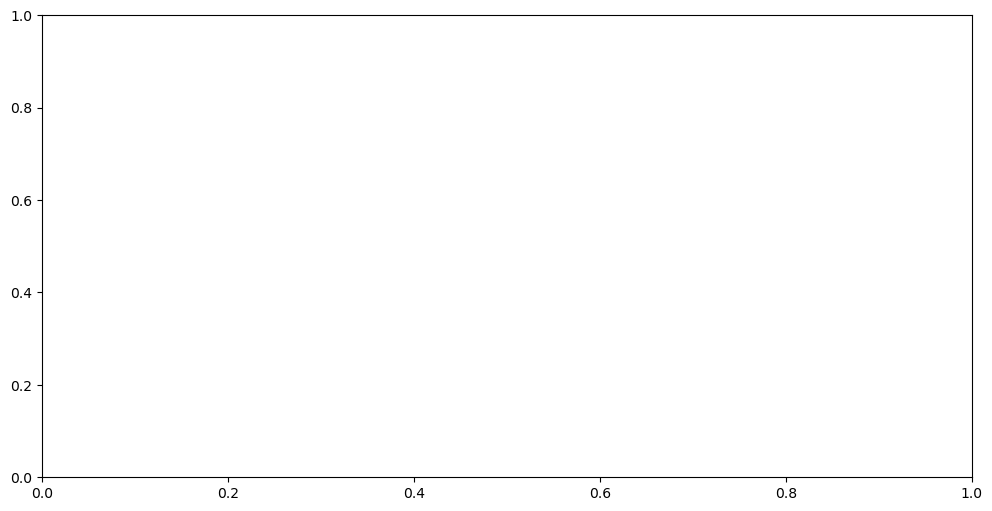

In [24]:
# Analyze inclination evolution in innermost region (0.015-0.025 AU)
innermost_particles = []
n_planets = 6

for i, particle in enumerate(initial_test_particles):
    star = snapshots[0][0]
    p = snapshots[0][n_planets+1+i]
    elements = orbital_elements_from_binary([star, p], G=constants.G)
    a = elements[2].value_in(units.AU)
    
    if 0.015 <= a <= 0.025:
        innermost_particles.append(i)

if len(innermost_particles) > 0:
    print(f"Found {len(innermost_particles)} particles in innermost region (0.015-0.025 AU)")
    
    # Track inclination for a few sample particles
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot inclination evolution for up to 5 particles
    for idx in innermost_particles[:5]:
        inclinations = []
        for snapshot in snapshots:
            star = snapshot[0]
            particle = snapshot[n_planets+1+idx]
            elements = orbital_elements_from_binary([star, particle], G=constants.G)
            inc = elements[4].value_in(units.deg)
            inclinations.append(inc)
        
        ax.plot(times, inclinations, linewidth=1.5, label=f'Particle {idx}')
    
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Inclination (degrees)')
    ax.set_title('Inclination Evolution in Innermost Region (0.015-0.025 AU)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Mark the 196-year period if simulation is long enough
    if times[-1] >= 196:
        ax.axvline(196, color='red', linestyle='--', alpha=0.5, linewidth=2, label='196 yr period')
        for i in range(1, int(times[-1]/196) + 1):
            ax.axvline(196*i, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    print("\nLook for periodic oscillations with ~196 year period")
    print("This matches TOI-178b's own oscillation period")
else:
    print("No particles found in innermost region (0.015-0.025 AU)")
    print("Consider adding more particles in this region for detailed analysis")

### 7.4 Co-orbital Width Analysis

The study found co-orbital regions are ~30% wider for planets in the resonance chain, and ~52% wider for TOI-178b.

In [ ]:
# Analyze co-orbital regions
# Classical Hill radius: r_H = a * (m_planet / (3 * m_star))^(1/3)

def classical_hill_radius(a, m_planet, m_star):
    """Calculate classical Hill radius."""
    return a * (m_planet / (3 * m_star))**(1/3)

print("Co-orbital Region Analysis")
print("="*60)

for name, data in planet_data.items():
    a = data['a'] | units.AU
    m_p = data['mass'] | units.MEarth
    
    r_hill_classical = classical_hill_radius(a, m_p, star_mass)
    
    # Expected enhancement: 30% for resonant planets (c-g), 52% for planet b
    if name == 'b':
        enhancement = 1.52  # 52% wider
        print(f"\nPlanet {name} (OUTSIDE resonance chain):")
    else:
        enhancement = 1.30  # 30% wider
        print(f"\nPlanet {name} (IN resonance chain):")
    
    r_hill_observed = r_hill_classical * enhancement
    
    print(f"  Semi-major axis: {a.in_(units.AU):.4f} AU")
    print(f"  Classical Hill radius: {r_hill_classical.in_(units.AU):.6f} AU")
    print(f"  Expected observed width: {r_hill_observed.in_(units.AU):.6f} AU ({enhancement:.0%} of classical)")
    print(f"  Co-orbital range: {(a - r_hill_observed).in_(units.AU):.4f} - {(a + r_hill_observed).in_(units.AU):.4f} AU")

print("\n" + "="*60)
print("To verify: Check particle density around each planet location")
print("Should see enhanced accumulation within the predicted co-orbital ranges")

## 8. Cleanup

Stop the gravity code when done.

In [ ]:
gravity.stop()
print("Gravity code stopped successfully.")

---

## Summary: Replicating Boskovic et al. 2025

This notebook provides a framework to replicate the key findings from the study:

### ✅ **Implemented:**
1. **TOI-178 system setup** - 6 planets with 5 in 2:4:6:9:12 resonance chain
2. **Test particle integration** - 1000 particles across 0.015-0.14 AU
3. **Long-term evolution** - 1000 year simulation (captures 500-year clearing, 196-year oscillations)
4. **Analysis tools:**
   - Particle survival and distribution
   - Mean motion resonance locations (Kirkwood gaps)
   - Inclination oscillations in innermost region
   - Co-orbital width predictions

### 🔍 **Key Results to Validate:**
- [ ] **Co-orbital widths**: 30% enhancement for resonant planets (c-g), 52% for planet b
- [ ] **Kirkwood gaps**: Clearing at 4:3, 5:4, 6:5 (with f) and 5:3 (with g) resonances
- [ ] **Clearing timescale**: ~500 years in resonant gaps
- [ ] **Inclination period**: 196-year oscillations in 0.015-0.025 AU region

### 🚀 **Extensions:**
- Increase integration time for better statistics
- Higher particle density in specific regions of interest
- Calculate MEGNO or Lyapunov exponents for stability analysis
- Create stability maps (a-e or a-i diagrams)
- Compare with observed debris disk structure (if available)

### 📚 **Reference:**
Boskovic, J., Sfair, R., & Schäfer, C. M. (2025). Particle dynamics in TOI-178 planetary system. 
arXiv:2509.07930. Accepted for publication in EPJS.